In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [13]:
# 데이터 불러오기
df = pd.read_csv("원시데이터.csv")  # 같은 폴더에 저장된 파일을 사용하세요

# 전처리
df = df.dropna()
target_col = "HE_DM_HbA1c"  # 타겟 변수명

# 숫자형 변수만 필터링
X = df.drop(columns=[target_col])
X = X.select_dtypes(include=['int64', 'float64'])
y = df[target_col]

In [14]:
# 학습 데이터 분리 및 모델 학습
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# SHAP 값 처리 (mean across classes)
import numpy as np
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# 다차원 SHAP 처리
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_values_class = shap_values.mean(axis=2)
elif isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_class = shap_values[1]
elif isinstance(shap_values, list):
    shap_values_class = sum(shap_values) / len(shap_values)
else:
    shap_values_class = shap_values

# SHAP DataFrame 생성
shap_df = pd.DataFrame(shap_values_class, columns=X.columns)

# ✅ 여기가 빠지면 안됨!
cor_matrix = shap_df.corr()


In [16]:
# 네트워크 생성
G = nx.Graph()
threshold = 0.4
for i in range(len(cor_matrix.columns)):
    for j in range(i+1, len(cor_matrix.columns)):
        corr_val = cor_matrix.iloc[i, j]
        if abs(corr_val) >= threshold:
            G.add_edge(cor_matrix.columns[i], cor_matrix.columns[j], weight=corr_val)

In [18]:
# 중심성 계산
centrality = nx.degree_centrality(G)

# 상위 3개 노드 기준으로 색 구분
top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:3]
node_colors = ['tomato' if node in top_nodes else 'skyblue' for node in G.nodes]


In [19]:
# 특정 유저의 상위 3개 중요 변수
user_idx = 0
top3_user_feats = shap_df.iloc[user_idx].abs().sort_values(ascending=False).head(3).index.tolist()

# 노드 색 업데이트 (겹치는 경우 빨간색 우선)
node_colors = []
for node in G.nodes:
    if node in top3_user_feats:
        node_colors.append('orange')
    elif node in top_nodes:
        node_colors.append('tomato')
    else:
        node_colors.append('skyblue')


C:\Users\asia\AppData\Local\Temp\ipykernel_17088\1414727518.py:12: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_17088\1414727518.py:12: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_17088\1414727518.py:12: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_17088\1414727518.py:12: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_17088\1414727518.py:12: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_17088\1414727518.py:12: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from fo

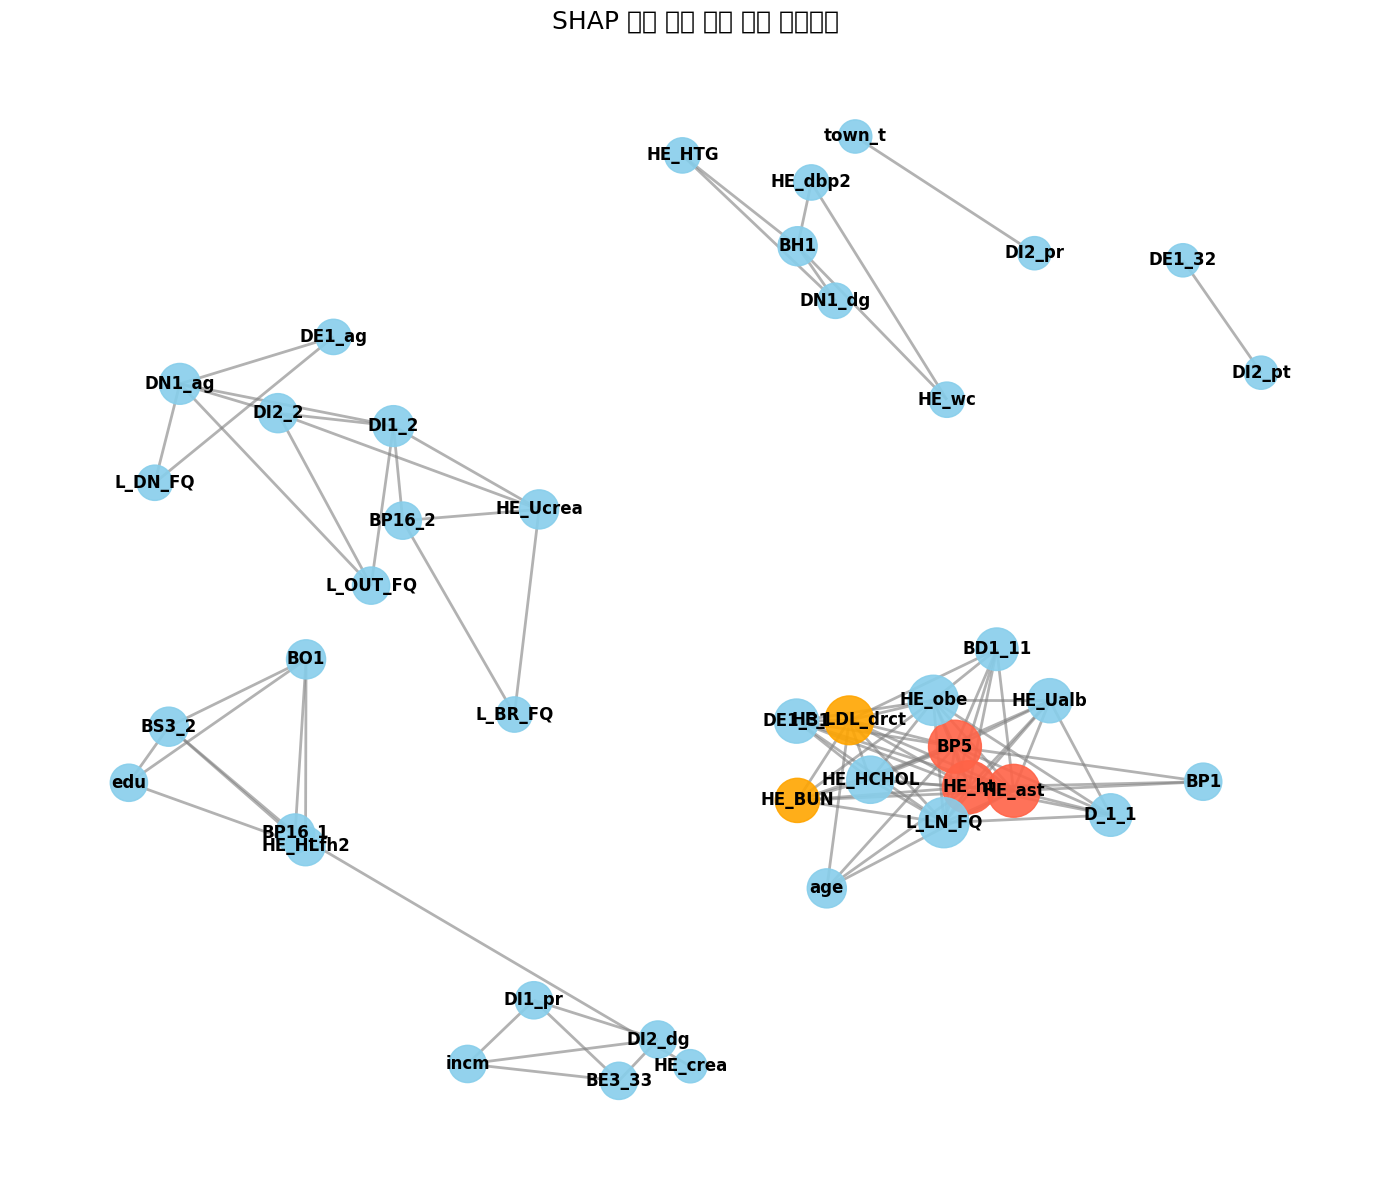

In [20]:
# 시각화
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)
node_sizes = [500 + 3000 * centrality[n] for n in G.nodes]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')

plt.title("SHAP 기반 건강 변수 상관 네트워크", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()



In [21]:
# 설명 멘트 생성 함수
def generate_explanation(user_idx):
    user_data = X_train.iloc[user_idx]
    user_shap = shap_df.iloc[user_idx]
    top_features = user_shap.abs().sort_values(ascending=False).head(3).index.tolist()

    ment = f"당신이 '{target_col}' 위험군으로 분류된 주요 원인은 다음 요인들의 결합입니다:\n"
    for feat in top_features:
        ment += f"▸ {feat}: {user_data[feat]}\n"

    ment += "\n이 요인들은 유사군 내에서 함께 나타나는 경향이 있으며, 건강 위험도를 증가시키는 주요 경로로 작용합니다."
    return ment

In [22]:
# 예시 유저 멘트 출력
print(generate_explanation(0))

당신이 'HE_DM_HbA1c' 위험군으로 분류된 주요 원인은 다음 요인들의 결합입니다:
▸ HE_HbA1c: 5.1
▸ HE_BUN: 15.0
▸ HE_LDL_drct: 127.0

이 요인들은 유사군 내에서 함께 나타나는 경향이 있으며, 건강 위험도를 증가시키는 주요 경로로 작용합니다.


mysql 연동

In [23]:
!pip install pymysql
import pymysql
conn=pymysql.connect(host='127.0.0.1',user='root', password='1234', db='employees', charset='utf8')

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\anaconda3\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [24]:
cur=conn.cursor()
cur.execute("CREATE TABLE IF NOT EXISTS userTable (id char(4), userName char(15), email char(20), birthYear int)")

0

In [25]:
cur.execute("INSERT INTO userTable VALUES( 'john' , 'John Bann' ,'john@naver.com',1990)")
cur.execute("INSERT INTO userTable VALUES( 'kim' , 'Kim Chi' ,'kim@daum.net' , 1992)")
cur.execute("INSERT INTO userTable VALUES( 'lee' , 'Lee Pal' ,'lee@paran.com', 1988)")
cur.execute("INSERT INTO userTable VALUES( 'park' , 'Park Su' ,'park@gmail.com' , 1980)")

1

In [26]:
conn.commit

<bound method Connection.commit of <pymysql.connections.Connection object at 0x0000023993441580>>

In [27]:
conn.close()

In [28]:
import pymysql

# 전역변수 선언부
conn, cur = None, None
data1, data2, data3, data4 = "","","",""
sql=""

# 메인 코드
conn = pymysql.connect(host='127.0.0.1', user='root', password='1234',
db='employees', charset='utf8')
cur = conn.cursor()

In [ ]:
while (True):
data1 = input("사용자 ID == > ")
if data1
break;
data2 = input("사용자 이름 == > ")
data3 = input("사용자 이메일 == > ")
data4 = input("사용자 출생녀도 == > ")
"INSERT INTO userTable VALUES('" + data1 + "','" + data2 + "','" +
data3 + "'," + data4 + ")"
cur.execute(sal)

conn.commit()
conn.close()

:

==

sal